## Data processing and EDA

In [14]:
#Import matplot
import matplotlib.pyplot as plt

#Vader sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Load additional packages
import time
import datetime
import numpy as np
import pandas as pd
import requests
from collections import Counter
import itertools
import re
import itertools
import sys
from retry import retry
import os
import dotenv

pd.set_option('display.max_colwidth', None)
%matplotlib inline

### Define Functions

Function to convert timestamp to a datetime object

In [15]:
def to_time(t):
    date_time_obj = datetime.datetime.strptime(t,'%Y-%m-%d %H:%M:%S').date()
    return date_time_obj

Function to interpret the dicky fuller test results

In [16]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2],index=['Test Statistic','p-value'])
    return dfoutput

Function to classify and count mentions of a given stock

In [17]:
def classify(word,stock):
    if word == stock:
        return 1
    else:
        return 0

### Pull historical stock information for GME

This step must be repeated for each new key:value pair you'd like to store as local varaible. For the purpose of this repository, only four are required. Your twitter api key, api secret key, access token and access token secret. 

Below is an empty dictionary for you to copy paste your twitter api keys into

In [18]:
#alpha_apikey = ''

Copy paste each key value pair into the code below and run it for each key, value pair in order to save these as local environment variables

In [19]:
#Look for .env file and assign file path
dotenv_file = dotenv.find_dotenv()
#Load the .env file for editing
dotenv.load_dotenv(dotenv_file)
#Overwrite the os.environ dict with new key:value pair
os.environ['key'] = 'value'
#Update the new dict 
dotenv.set_key(dotenv_file,'key',os.environ['key'])

UnboundLocalError: local variable 'dest' referenced before assignment

Set api and secret key variables for use in this script

In [ ]:
apikey = os.environ['alpha_apikey']

Grab GME price data from Jan 1st, 2021 to March 5th, 2021 using alpha advantage API

In [25]:
base_url = "https://www.alphavantage.co/query"
req_av = requests.get(base_url,params={'function':'TIME_SERIES_DAILY',
                                       'symbol':'GME',
                                      'apikey':apikey,'outputsize':'full'}) 

req_av.status_code
req_av.url
gme = req_av.json()
gme['Time Series (Daily)']
df = pd.DataFrame(gme['Time Series (Daily)'])
df = df.T
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df = df['2021']
df['1. open'] = pd.to_numeric(df['1. open'], downcast="float")
df['2. high'] = pd.to_numeric(df['2. high'], downcast="float")
df['3. low'] = pd.to_numeric(df['3. low'], downcast="float")
df['4. close'] = pd.to_numeric(df['4. close'], downcast="float")
df['5. volume'] = pd.to_numeric(df['5. volume'], downcast="float")
s= df['4. close']
idx = pd.date_range('01-01-2021', '03-05-2021')
s = s.reindex(idx,method='nearest')

### Import historical twitter data for modelling

In [3]:
#Read in historical data
tweets = pd.read_csv('data/twitter_historical_05.03.21.csv')

#Drop the unnamed column 
tweets.drop(['Unnamed: 0'],axis=1,inplace=True)
tweets.dropna(subset=['tweet'],inplace=True)

/Users/noah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590667 entries, 0 to 590674
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                590667 non-null  float64
 1   screen_name       590667 non-null  object 
 2   created_at        590667 non-null  object 
 3   tweet             590667 non-null  object 
 4   followers         278868 non-null  float64
 5   processed_tweets  506393 non-null  object 
 6   stocks            25232 non-null   object 
dtypes: float64(2), object(5)
memory usage: 36.1+ MB


In [7]:
nj = pd.read_csv('data/twitter_live_2021-03-08.csv')
nj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3032 entries, 0 to 3031
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        3032 non-null   int64  
 1   screen_name       3032 non-null   object 
 2   created_at        3032 non-null   object 
 3   tweet             3032 non-null   object 
 4   retweets          3032 non-null   float64
 5   likes             3032 non-null   float64
 6   followers         444 non-null    float64
 7   processed_tweets  3032 non-null   object 
 8   stocks            69 non-null     object 
dtypes: float64(3), int64(1), object(5)
memory usage: 213.3+ KB


### EDA and data processing

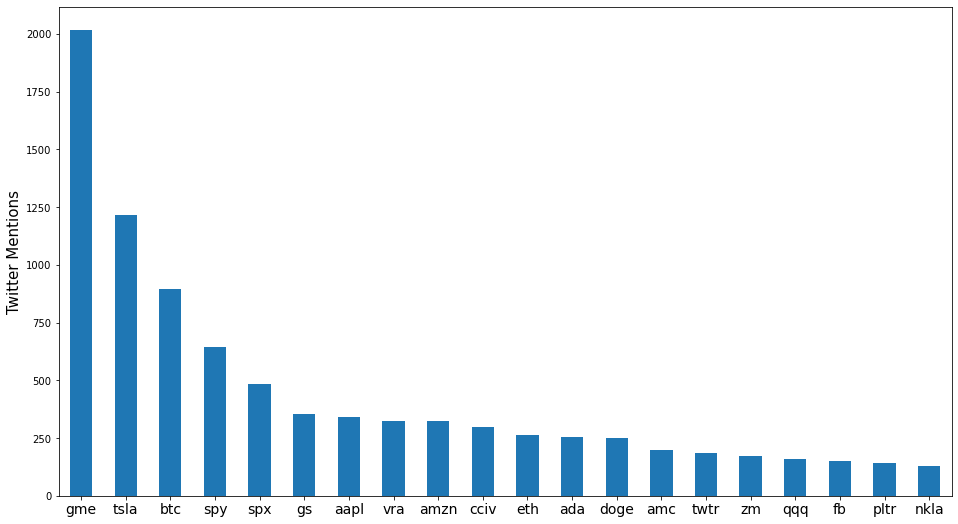

In [12]:
#Could train the model on GME alone so it can predict another outlier event like that...
fig,ax1 = plt.subplots(figsize=(16,9))
buzz = tweets.stocks.value_counts().nlargest(n=20)
buzz.plot.bar(x='Stocks',y='Mentions',rot=0)
ax1.tick_params(axis='x',labelsize=14)
ax1.set_ylabel('Twitter Mentions',fontsize=15);

In [28]:
#Instantiate sentiment analyzer 
sid = SentimentIntensityAnalyzer()

#Transform sentiment scores, date and processed tweets columns
tweets['scores'] = tweets['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
tweets['compound']  = tweets['scores'].apply(lambda score_dict: score_dict['compound'])
tweets['sentiment'] = tweets['compound'].apply(lambda c: 1 if c >0 else (0 if c==0 else -1))
tweets['created_at_transformed'] = tweets['created_at'].map(lambda x: x[:-6])
tweets['date'] = tweets['created_at_transformed'].apply(to_time)
tweets.dropna(subset = ['processed_tweets'],inplace=True)
tweets['processed_tweets'] = tweets['processed_tweets'].apply(lambda x: x.lower() if type(x) ==str else x)

Count the frequency of mentions for GME for further investigation

In [29]:
#GME mentions
tweets['mentions'] = tweets['stocks'].apply(classify,args=('$gme',))+tweets['processed_tweets'].str.contains('gamestop').astype(int) + tweets['processed_tweets'].str.contains('gme').astype(int)
tweets['mentions'] = tweets['mentions'].apply(lambda x: x/x if x>0 else x)

#Feature engineer weighred mentions
tweets['weighted_mentions'] = tweets['mentions']*tweets['followers']
tweets['mentions'].value_counts()

0.0    501373
1.0      5020
Name: mentions, dtype: int64

Create new dataframe to be aggregated up by time

In [30]:
#date,compound,sentiment (weighted?),stocks, followers
data = tweets[['date','weighted_mentions','mentions','followers']]

data.set_index('date',inplace=True)
data.sort_index(inplace=True)
data.dropna(inplace=True)
data.index = pd.to_datetime(data.index)

data = data['2021'].resample('D').sum()

<ipython-input-30-d9a32ebe8c76>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_index(inplace=True)
<ipython-input-30-d9a32ebe8c76>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Save pre-processed data to a CSV in data folder

In [17]:
tweets.to_csv('data/twitter_historical_05.03.21_pre-processed.csv')
data.to_csv('data/twitter_historical_05.03.21_pre-processed_agg_time.csv')
s.to_csv('data/gme_price.csv')

### EDA: GME Mentions vs Price

NameError: name 'data' is not defined

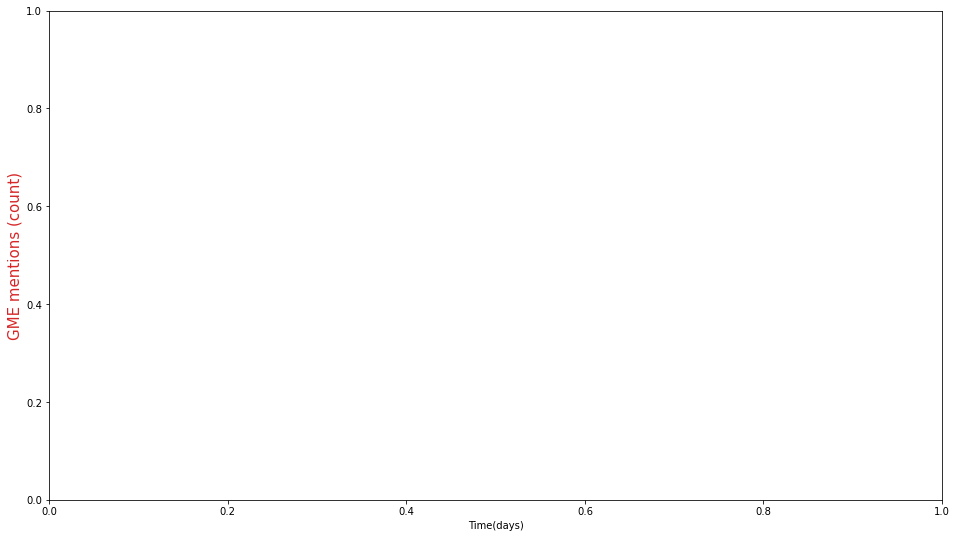

In [13]:
fig,ax1 = plt.subplots(figsize=(16,9))

#Axis 1
color = 'tab:red'
ax1.set_xlabel('Time(days)')
ax1.set_ylabel('GME mentions (count)',color=color,fontsize=15)
ax1.plot(data['mentions'],color=color)
ax1.tick_params(axis='y',labelcolor=color)
ax1.tick_params(axis='x',labelsize=14)

#Axis 2
ax2 =ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('GME Closing Price ($)',color=color)
ax2.plot(s,color=color)
ax2.tick_params(axis='y',labelcolor=color)

fig.tight_layout()
plt.show();

Combine twitter data and GME price data tables into one for modelling

In [32]:
merge1 = data[['mentions','followers']]
merge2 = s
merge=pd.merge(merge1,merge2, how='inner', left_index=True, right_index=True)
merge.rename(columns={
    '4. close':'price'
},inplace=True)

merge.corr()

,mentions,followers,price
mentions,1.000000,0.134394,0.620159
followers,0.134394,1.000000,0.167017
price,0.620159,0.167017,1.000000


In [35]:
round(merge.corr()['mentions']['price'],2)

0.62

62% correlation between count of mentions and the price action

### EDA: GME Weighted Mentions vs Price

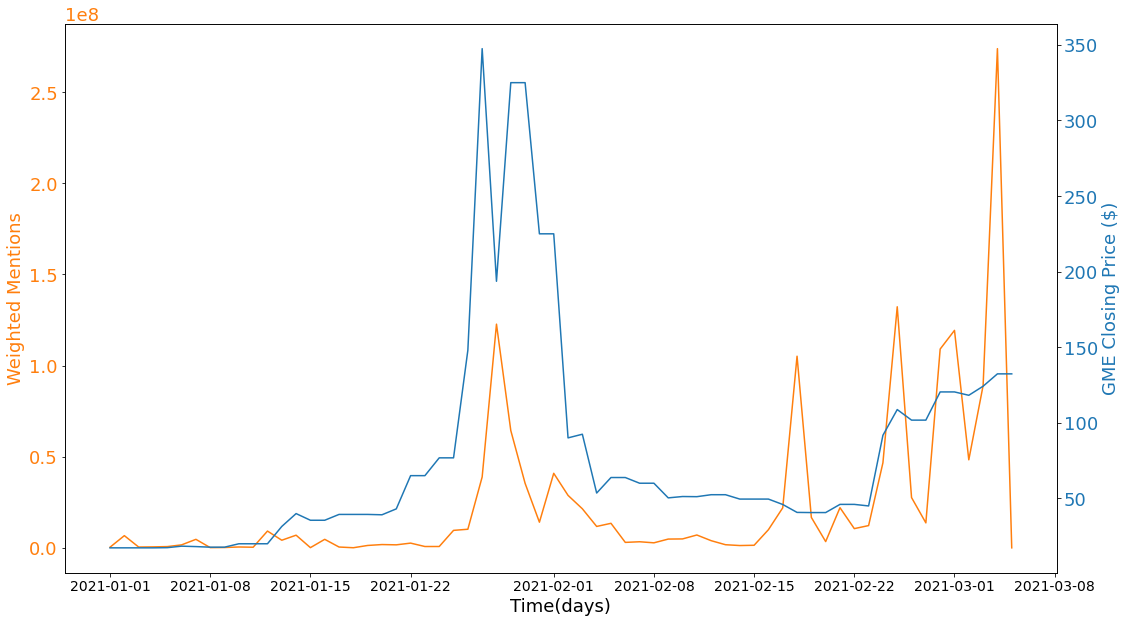

In [819]:
fig,ax1 = plt.subplots(figsize=(16,9))
plt.rcParams.update({'font.size':18})


#Axis 1
color = 'tab:orange'
ax1.set_xlabel('Time(days)')
ax1.set_ylabel('Weighted Mentions',color=color)
ax1.plot(data['weighted_mentions'],color=color)
ax1.tick_params(axis='y',labelcolor=color)
ax1.tick_params(axis='x',labelsize=14)

#Axis 2
ax2 =ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('GME Closing Price ($)',color=color)
ax2.plot(s,color=color)
ax2.tick_params(axis='y',labelcolor=color)

fig.tight_layout()
plt.show();

Combine twitter data and GME price data tables into one for modelling

In [820]:
merge3 = data['weighted_mentions']
merge2 = s
merged=pd.merge(merge2,merge3, how='inner', left_index=True, right_index=True)
merged.corr()

,4. close,weighted_mentions
4. close,1.000000,0.394518
weighted_mentions,0.394518,1.000000


Weighted mentions are not as highly correlated

### Descriptive statsitics

Calculate and graph the 7 day rolling average of mentions for GME leading up to the event

In [877]:
data['sev_day_ma'] = data['mentions'].rolling(7).mean()

In [883]:
merge4 = data['sev_day_ma']
merge2 = s
merged_ma=pd.merge(merge2,merge4, how='inner', left_index=True, right_index=True)

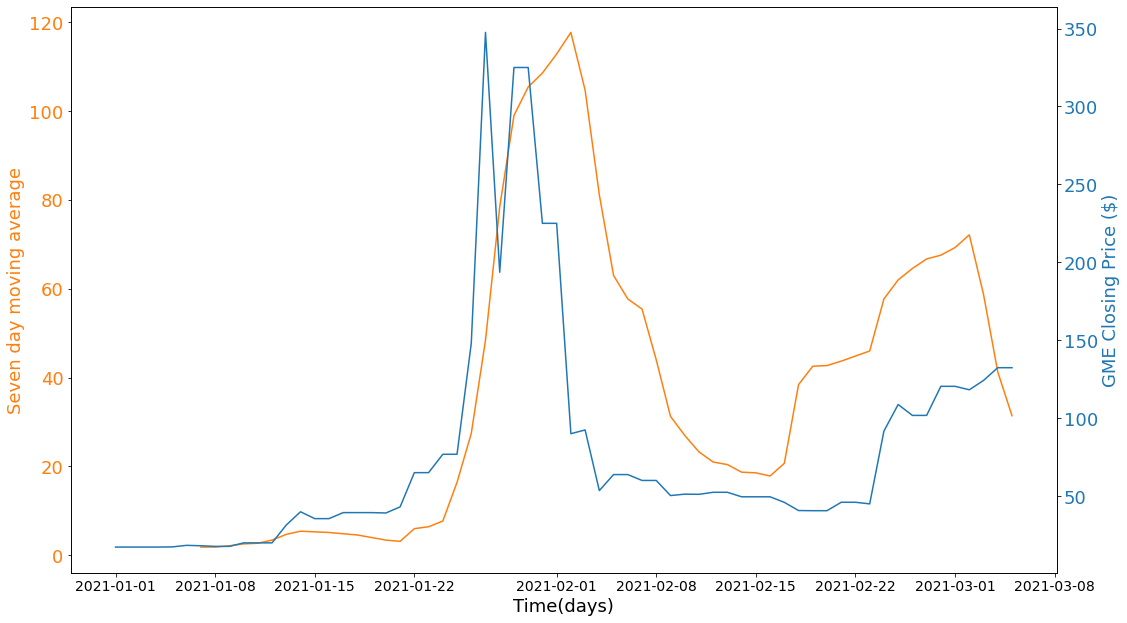

In [889]:
fig,ax1 = plt.subplots(figsize=(16,9))
plt.rcParams.update({'font.size':18})


#Axis 1
color = 'tab:orange'
ax1.set_xlabel('Time(days)')
ax1.set_ylabel('Seven day moving average',color=color)
ax1.plot(data['sev_day_ma'],color=color)
ax1.tick_params(axis='y',labelcolor=color)
ax1.tick_params(axis='x',labelsize=14)

#Axis 2
ax2 =ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('GME Closing Price ($)',color=color)
ax2.plot(s,color=color)
ax2.tick_params(axis='y',labelcolor=color)

fig.tight_layout()
plt.show();

In [885]:
merged_ma.corr()

,4. close,sev_day_ma
4. close,1.00000,0.65972
sev_day_ma,0.65972,1.00000


In [900]:
data['delta_flag'] = data['sev_day_ma'].apply(lambda x: 1 if x>30 else 0)

### Number of outliers as a percetage of days

In [895]:
#Filter dataframe
outliers = pd.DataFrame(data['mentions'])
#Calculate outliers
Q1=outliers.quantile(0.25)
Q3=outliers.quantile(0.75)
IQR=Q3-Q1
outlier_count = round((((outliers < (Q1 - 1.5 * IQR)) | (outliers > (Q3 + 1.5 * IQR))).sum()/outliers.count()).sort_values(ascending=False),2)
outlier_count

mentions    0.09
dtype: float64

### Data Export

Export processed data to a csv in the data folder

In [844]:
merge.to_csv('data/twitter_historical_merge.csv')